# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

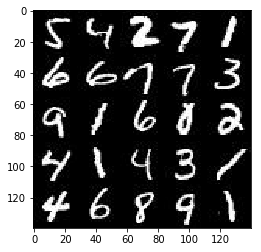

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot
import numpy as np

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

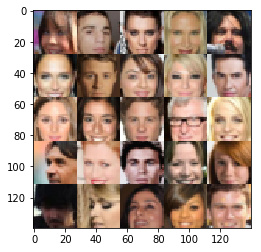

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/home/ww/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_image = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name ="input_real")
    z_data = tf.placeholder(tf.float32, shape=(None, z_dim), name="input_z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return real_image, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.1
    
    with tf.variable_scope("discriminator", reuse=reuse):
        dis_conv1 = tf.layers.conv2d(images, 32, 5, strides=2, padding='same')
        dis_conv1 = tf.maximum(alpha*dis_conv1, dis_conv1)
        # 14x14x32
        dis_conv2 = tf.layers.conv2d(dis_conv1, 64, 5, strides=2, padding='same')
        dis_conv2 = tf.layers.batch_normalization(dis_conv2, training=True)
        dis_conv2 = tf.maximum(alpha*dis_conv2, dis_conv2)
        # 7x7x64
        
        dis_conv3 = tf.layers.conv2d(dis_conv2, 128, 5, strides=1, padding='same')
        dis_conv3 = tf.layers.batch_normalization(dis_conv3, training=True)
        dis_conv3 = tf.maximum(alpha*dis_conv3, dis_conv3)
        #7x7x128
        
        flat = tf.reshape(dis_conv3, (-1, 7*7*128))
        logits = tf.layers.dense(flat, 1)
        out = tf.nn.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.1
    with tf.variable_scope("generator", reuse=not is_train):
        de_full1 = tf.layers.dense(z, 7*7*256)
        de_full1 = tf.reshape(de_full1, (-1, 7, 7, 256))
        de_full1 = tf.layers.batch_normalization(de_full1, training=is_train)
        de_full1 = tf.maximum(alpha*de_full1, de_full1)
        #7x7x256
        
        de_conv1 = tf.layers.conv2d_transpose(de_full1, 128, 5, strides=2,padding='same')
        de_conv1 = tf.layers.batch_normalization(de_conv1, training=is_train)
        de_conv1 = tf.maximum(alpha*de_conv1, de_conv1)
        #14x14x128
        
        de_conv2 = tf.layers.conv2d_transpose(de_conv1, 64, 5, strides=2, padding='same')
        de_conv2 = tf.layers.batch_normalization(de_conv2, training=is_train)
        de_conv2 = tf.maximum(alpha*de_conv2, de_conv2)
        #28*28*64
        
        logits = tf.layers.conv2d_transpose(de_conv2, out_channel_dim, 5, strides=1, padding='same')
        #28x28x3
        out = tf.tanh(logits)
        
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real,  reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=(tf.ones_like(d_model_real) * np.random.uniform(0.7, 1.2))))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=(tf.zeros_like(d_model_fake) * np.random.uniform(0.0, 0.3))))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits= d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real+d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    tvars = tf.trainable_variables()
    d_vars = [var for var in tvars if var.name.startswith('discriminator')]
    g_vars = [var for var in tvars if var.name.startswith('generator')]
    
    #d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    #update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    #gen_updates = [opt for opt in update_ops if opt.name.startswith('generator')]
    
    #with tf.control_dependencies(gen_updates):
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
#import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
   
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #tf.reset_default_graph()
    #print("data_shape", type(data_shape), data_shape)
    
    image_width=data_shape[1]
    image_height=data_shape[2]
    image_channels = data_shape[3]
    print("image_width:", image_width, "image_height:",image_height, 
          "image_channels:",image_channels, "data_num:",data_shape[0], "batch_num: ", data_shape[0]//batch_size)
    input_real, input_z, learningrate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learningrate, beta1)
    
    steps = 0
    print_every= 25
    show_every =  100
    losses = []
    saver = tf.train.Saver()

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2.0
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)).astype(np.float32)
                #print("batch_z", batch_z.dtype)
                #print("batch_images", batch_images.dtype)
                #print("learning_rate", type(learning_rate))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z,  learningrate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learningrate:learning_rate})
                
                if steps % print_every ==0:
                    train_loss_d = sess.run(d_loss, feed_dict={input_real:batch_images, input_z:batch_z})
                    train_loss_g = sess.run(g_loss, feed_dict={input_z:batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count), 
                          "Batch num {}/{}...".format(steps, data_shape[0]//batch_size),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, image_channels,data_image_mode)
                    
        saver.save(sess, './checkpoints/generator.ckpt')       
        
    return losses 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

image_width: 28 image_height: 28 image_channels: 1 data_num: 60000 batch_num:  937
Epoch 1/2... Batch num 25/937... Discriminator Loss: 2.5271... Generator Loss: 0.1607
Epoch 1/2... Batch num 50/937... Discriminator Loss: 1.4568... Generator Loss: 0.4664
Epoch 1/2... Batch num 75/937... Discriminator Loss: 1.7286... Generator Loss: 1.2053
Epoch 1/2... Batch num 100/937... Discriminator Loss: 1.4756... Generator Loss: 0.4502


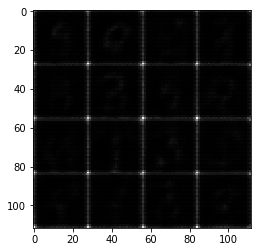

Epoch 1/2... Batch num 125/937... Discriminator Loss: 1.4778... Generator Loss: 0.8519
Epoch 1/2... Batch num 150/937... Discriminator Loss: 1.3502... Generator Loss: 0.5492
Epoch 1/2... Batch num 175/937... Discriminator Loss: 1.4397... Generator Loss: 0.4511
Epoch 1/2... Batch num 200/937... Discriminator Loss: 1.2127... Generator Loss: 0.8178


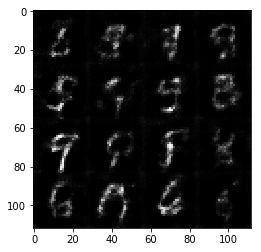

Epoch 1/2... Batch num 225/937... Discriminator Loss: 1.4588... Generator Loss: 0.4248
Epoch 1/2... Batch num 250/937... Discriminator Loss: 1.4312... Generator Loss: 0.4245
Epoch 1/2... Batch num 275/937... Discriminator Loss: 1.3429... Generator Loss: 0.4961
Epoch 1/2... Batch num 300/937... Discriminator Loss: 1.3302... Generator Loss: 1.2110


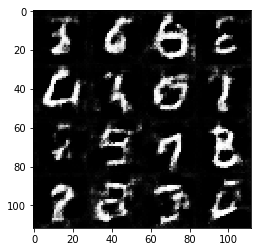

Epoch 1/2... Batch num 325/937... Discriminator Loss: 1.4507... Generator Loss: 1.4991
Epoch 1/2... Batch num 350/937... Discriminator Loss: 1.4806... Generator Loss: 0.3625
Epoch 1/2... Batch num 375/937... Discriminator Loss: 1.3646... Generator Loss: 1.0233
Epoch 1/2... Batch num 400/937... Discriminator Loss: 1.4597... Generator Loss: 0.4181


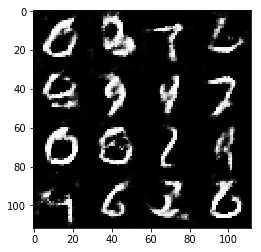

Epoch 1/2... Batch num 425/937... Discriminator Loss: 1.4366... Generator Loss: 0.4114
Epoch 1/2... Batch num 450/937... Discriminator Loss: 1.2554... Generator Loss: 1.3255
Epoch 1/2... Batch num 475/937... Discriminator Loss: 1.2371... Generator Loss: 1.2127
Epoch 1/2... Batch num 500/937... Discriminator Loss: 1.3154... Generator Loss: 0.9039


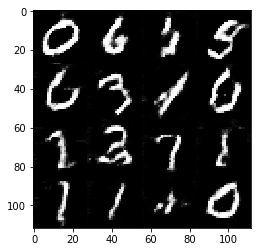

Epoch 1/2... Batch num 525/937... Discriminator Loss: 1.0779... Generator Loss: 1.0423
Epoch 1/2... Batch num 550/937... Discriminator Loss: 1.3342... Generator Loss: 0.5471
Epoch 1/2... Batch num 575/937... Discriminator Loss: 1.1469... Generator Loss: 0.9038
Epoch 1/2... Batch num 600/937... Discriminator Loss: 1.2020... Generator Loss: 0.7088


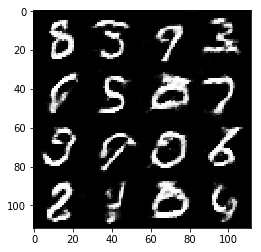

Epoch 1/2... Batch num 625/937... Discriminator Loss: 1.0463... Generator Loss: 0.9637
Epoch 1/2... Batch num 650/937... Discriminator Loss: 1.1108... Generator Loss: 0.9205
Epoch 1/2... Batch num 675/937... Discriminator Loss: 1.3157... Generator Loss: 0.4732
Epoch 1/2... Batch num 700/937... Discriminator Loss: 1.1899... Generator Loss: 0.6658


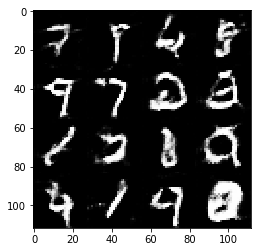

Epoch 1/2... Batch num 725/937... Discriminator Loss: 1.1387... Generator Loss: 0.6391
Epoch 1/2... Batch num 750/937... Discriminator Loss: 1.0918... Generator Loss: 0.9770
Epoch 1/2... Batch num 775/937... Discriminator Loss: 1.3441... Generator Loss: 0.4677
Epoch 1/2... Batch num 800/937... Discriminator Loss: 1.1469... Generator Loss: 0.7571


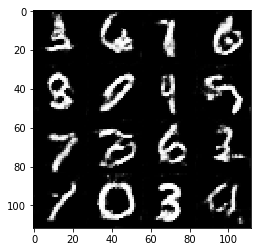

Epoch 1/2... Batch num 825/937... Discriminator Loss: 2.1473... Generator Loss: 0.1900
Epoch 1/2... Batch num 850/937... Discriminator Loss: 1.5271... Generator Loss: 0.3621
Epoch 1/2... Batch num 875/937... Discriminator Loss: 1.2422... Generator Loss: 0.7748
Epoch 1/2... Batch num 900/937... Discriminator Loss: 2.0221... Generator Loss: 0.2043


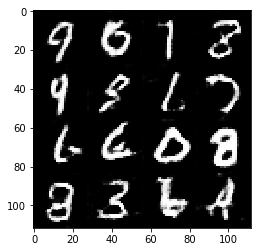

Epoch 1/2... Batch num 925/937... Discriminator Loss: 1.3626... Generator Loss: 0.4699
Epoch 2/2... Batch num 950/937... Discriminator Loss: 1.0785... Generator Loss: 1.1633
Epoch 2/2... Batch num 975/937... Discriminator Loss: 1.2968... Generator Loss: 0.6132
Epoch 2/2... Batch num 1000/937... Discriminator Loss: 1.4104... Generator Loss: 0.4212


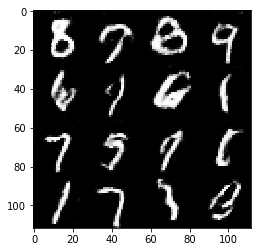

Epoch 2/2... Batch num 1025/937... Discriminator Loss: 1.3054... Generator Loss: 1.1445
Epoch 2/2... Batch num 1050/937... Discriminator Loss: 1.2962... Generator Loss: 0.5107
Epoch 2/2... Batch num 1075/937... Discriminator Loss: 1.5824... Generator Loss: 0.3409
Epoch 2/2... Batch num 1100/937... Discriminator Loss: 1.0019... Generator Loss: 0.8536


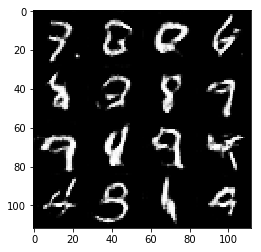

Epoch 2/2... Batch num 1125/937... Discriminator Loss: 1.2003... Generator Loss: 0.6314
Epoch 2/2... Batch num 1150/937... Discriminator Loss: 1.5348... Generator Loss: 2.1619
Epoch 2/2... Batch num 1175/937... Discriminator Loss: 1.2709... Generator Loss: 1.7599
Epoch 2/2... Batch num 1200/937... Discriminator Loss: 1.2750... Generator Loss: 0.5540


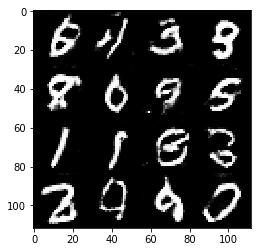

Epoch 2/2... Batch num 1225/937... Discriminator Loss: 1.0857... Generator Loss: 0.8267
Epoch 2/2... Batch num 1250/937... Discriminator Loss: 1.0100... Generator Loss: 0.9753
Epoch 2/2... Batch num 1275/937... Discriminator Loss: 1.0971... Generator Loss: 1.1350
Epoch 2/2... Batch num 1300/937... Discriminator Loss: 0.9927... Generator Loss: 0.7898


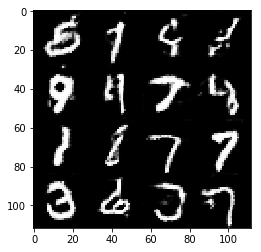

Epoch 2/2... Batch num 1325/937... Discriminator Loss: 1.1009... Generator Loss: 1.5607
Epoch 2/2... Batch num 1350/937... Discriminator Loss: 1.0516... Generator Loss: 0.7524
Epoch 2/2... Batch num 1375/937... Discriminator Loss: 1.2603... Generator Loss: 0.6080
Epoch 2/2... Batch num 1400/937... Discriminator Loss: 1.0158... Generator Loss: 0.8821


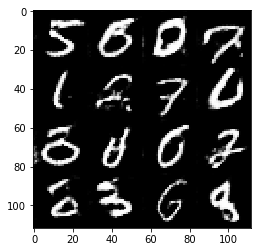

Epoch 2/2... Batch num 1425/937... Discriminator Loss: 1.0938... Generator Loss: 1.1386
Epoch 2/2... Batch num 1450/937... Discriminator Loss: 1.2335... Generator Loss: 1.8040
Epoch 2/2... Batch num 1475/937... Discriminator Loss: 0.9410... Generator Loss: 0.9951
Epoch 2/2... Batch num 1500/937... Discriminator Loss: 1.1107... Generator Loss: 0.7961


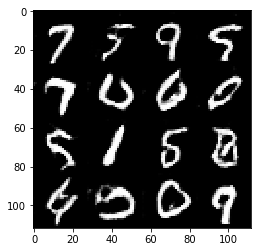

Epoch 2/2... Batch num 1525/937... Discriminator Loss: 1.1319... Generator Loss: 0.5907
Epoch 2/2... Batch num 1550/937... Discriminator Loss: 1.1828... Generator Loss: 1.8442
Epoch 2/2... Batch num 1575/937... Discriminator Loss: 1.0226... Generator Loss: 1.3593
Epoch 2/2... Batch num 1600/937... Discriminator Loss: 1.1267... Generator Loss: 0.6484


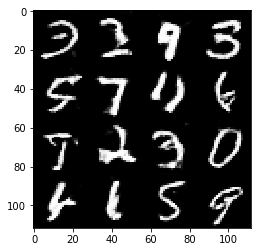

Epoch 2/2... Batch num 1625/937... Discriminator Loss: 1.1548... Generator Loss: 0.6440
Epoch 2/2... Batch num 1650/937... Discriminator Loss: 0.9400... Generator Loss: 1.1953
Epoch 2/2... Batch num 1675/937... Discriminator Loss: 1.1775... Generator Loss: 0.5833
Epoch 2/2... Batch num 1700/937... Discriminator Loss: 1.4112... Generator Loss: 0.5251


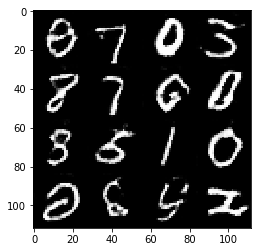

Epoch 2/2... Batch num 1725/937... Discriminator Loss: 0.9019... Generator Loss: 1.3286
Epoch 2/2... Batch num 1750/937... Discriminator Loss: 1.1384... Generator Loss: 0.6425
Epoch 2/2... Batch num 1775/937... Discriminator Loss: 1.0298... Generator Loss: 0.7635
Epoch 2/2... Batch num 1800/937... Discriminator Loss: 1.0314... Generator Loss: 0.9151


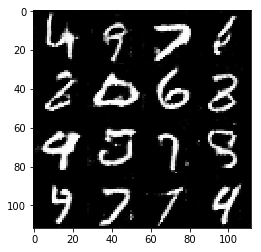

Epoch 2/2... Batch num 1825/937... Discriminator Loss: 0.9588... Generator Loss: 0.9153
Epoch 2/2... Batch num 1850/937... Discriminator Loss: 1.4272... Generator Loss: 0.4360


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.4

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
   losses =  train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

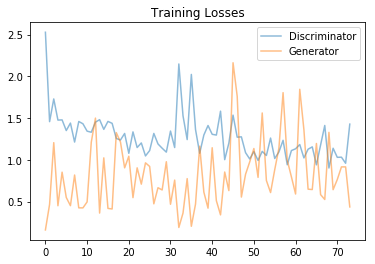

In [13]:
import matplotlib.pylab as plt

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

image_width: 28 image_height: 28 image_channels: 3 data_num: 202599 batch_num:  3165
Epoch 1/1... Batch num 25/3165... Discriminator Loss: 4.5276... Generator Loss: 0.0087
Epoch 1/1... Batch num 50/3165... Discriminator Loss: 0.6181... Generator Loss: 0.9488
Epoch 1/1... Batch num 75/3165... Discriminator Loss: 0.1279... Generator Loss: 2.7675
Epoch 1/1... Batch num 100/3165... Discriminator Loss: 0.9959... Generator Loss: 6.4825


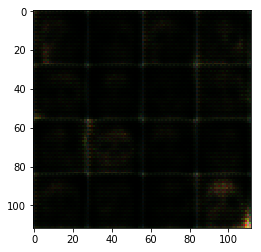

Epoch 1/1... Batch num 125/3165... Discriminator Loss: -0.0046... Generator Loss: 1.3574
Epoch 1/1... Batch num 150/3165... Discriminator Loss: 2.1087... Generator Loss: 2.8955
Epoch 1/1... Batch num 175/3165... Discriminator Loss: 2.9848... Generator Loss: 0.0414
Epoch 1/1... Batch num 200/3165... Discriminator Loss: 1.6638... Generator Loss: 0.2092


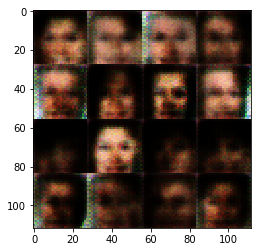

Epoch 1/1... Batch num 225/3165... Discriminator Loss: 2.7603... Generator Loss: 0.0663
Epoch 1/1... Batch num 250/3165... Discriminator Loss: 1.0276... Generator Loss: 0.5751
Epoch 1/1... Batch num 275/3165... Discriminator Loss: 0.9224... Generator Loss: 1.2058
Epoch 1/1... Batch num 300/3165... Discriminator Loss: 1.3092... Generator Loss: 0.8695


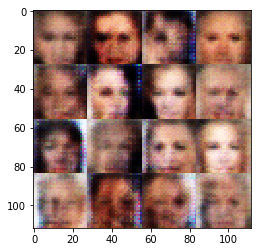

Epoch 1/1... Batch num 325/3165... Discriminator Loss: 1.4475... Generator Loss: 0.3488
Epoch 1/1... Batch num 350/3165... Discriminator Loss: 1.3292... Generator Loss: 0.3452
Epoch 1/1... Batch num 375/3165... Discriminator Loss: 1.3767... Generator Loss: 0.6044
Epoch 1/1... Batch num 400/3165... Discriminator Loss: 1.3803... Generator Loss: 0.7071


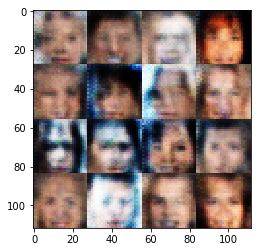

Epoch 1/1... Batch num 425/3165... Discriminator Loss: 1.2486... Generator Loss: 0.5280
Epoch 1/1... Batch num 450/3165... Discriminator Loss: 0.5106... Generator Loss: 1.9875
Epoch 1/1... Batch num 475/3165... Discriminator Loss: 0.7080... Generator Loss: 0.6704
Epoch 1/1... Batch num 500/3165... Discriminator Loss: 2.1078... Generator Loss: 0.1027


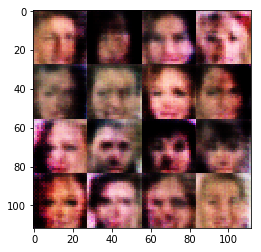

Epoch 1/1... Batch num 525/3165... Discriminator Loss: 1.4434... Generator Loss: 0.4260
Epoch 1/1... Batch num 550/3165... Discriminator Loss: 1.0896... Generator Loss: 1.5020
Epoch 1/1... Batch num 575/3165... Discriminator Loss: 0.9017... Generator Loss: 0.6813
Epoch 1/1... Batch num 600/3165... Discriminator Loss: 1.2934... Generator Loss: 0.5276


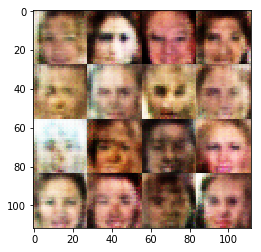

Epoch 1/1... Batch num 625/3165... Discriminator Loss: 1.5346... Generator Loss: 0.5600
Epoch 1/1... Batch num 650/3165... Discriminator Loss: 1.2988... Generator Loss: 0.5313
Epoch 1/1... Batch num 675/3165... Discriminator Loss: 1.3214... Generator Loss: 0.6246
Epoch 1/1... Batch num 700/3165... Discriminator Loss: 1.4411... Generator Loss: 0.6028


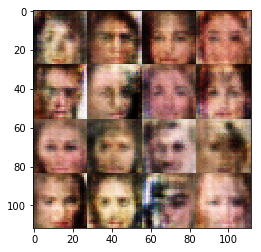

Epoch 1/1... Batch num 725/3165... Discriminator Loss: 1.3512... Generator Loss: 0.5303
Epoch 1/1... Batch num 750/3165... Discriminator Loss: 1.4564... Generator Loss: 0.3798
Epoch 1/1... Batch num 775/3165... Discriminator Loss: 1.1164... Generator Loss: 0.4539
Epoch 1/1... Batch num 800/3165... Discriminator Loss: 1.8379... Generator Loss: 0.1452


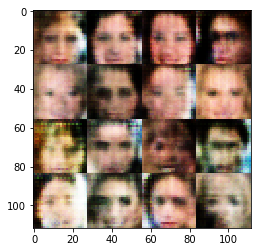

Epoch 1/1... Batch num 825/3165... Discriminator Loss: 1.4620... Generator Loss: 0.2003
Epoch 1/1... Batch num 850/3165... Discriminator Loss: 1.5725... Generator Loss: 0.2262
Epoch 1/1... Batch num 875/3165... Discriminator Loss: 1.4314... Generator Loss: 0.3029
Epoch 1/1... Batch num 900/3165... Discriminator Loss: 0.9974... Generator Loss: 0.5045


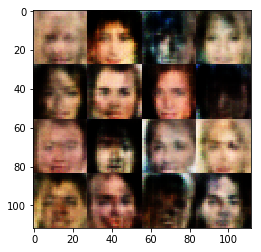

Epoch 1/1... Batch num 925/3165... Discriminator Loss: 1.4051... Generator Loss: 0.4251
Epoch 1/1... Batch num 950/3165... Discriminator Loss: 1.3262... Generator Loss: 0.4527
Epoch 1/1... Batch num 975/3165... Discriminator Loss: 1.3627... Generator Loss: 0.2577
Epoch 1/1... Batch num 1000/3165... Discriminator Loss: 2.4154... Generator Loss: 1.8720


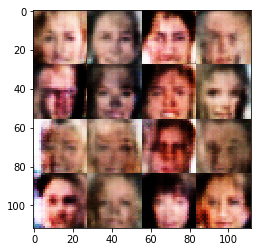

Epoch 1/1... Batch num 1025/3165... Discriminator Loss: 1.8148... Generator Loss: 0.6814
Epoch 1/1... Batch num 1050/3165... Discriminator Loss: 1.4676... Generator Loss: 0.3714
Epoch 1/1... Batch num 1075/3165... Discriminator Loss: 1.0915... Generator Loss: 0.4983
Epoch 1/1... Batch num 1100/3165... Discriminator Loss: 0.9487... Generator Loss: 0.6618


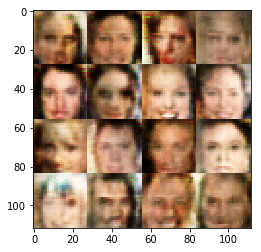

Epoch 1/1... Batch num 1125/3165... Discriminator Loss: 1.6779... Generator Loss: 0.7493
Epoch 1/1... Batch num 1150/3165... Discriminator Loss: 1.4101... Generator Loss: 0.3173
Epoch 1/1... Batch num 1175/3165... Discriminator Loss: 1.2021... Generator Loss: 0.4526
Epoch 1/1... Batch num 1200/3165... Discriminator Loss: 1.6568... Generator Loss: 0.2699


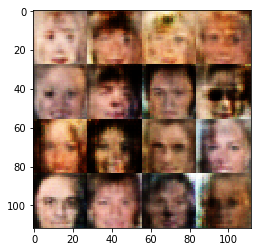

Epoch 1/1... Batch num 1225/3165... Discriminator Loss: 1.2502... Generator Loss: 0.5977
Epoch 1/1... Batch num 1250/3165... Discriminator Loss: 1.1548... Generator Loss: 0.6564
Epoch 1/1... Batch num 1275/3165... Discriminator Loss: 1.2081... Generator Loss: 0.3565
Epoch 1/1... Batch num 1300/3165... Discriminator Loss: 1.3275... Generator Loss: 0.5932


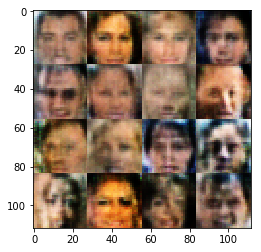

Epoch 1/1... Batch num 1325/3165... Discriminator Loss: 1.2294... Generator Loss: 0.6398
Epoch 1/1... Batch num 1350/3165... Discriminator Loss: 1.0430... Generator Loss: 1.0025
Epoch 1/1... Batch num 1375/3165... Discriminator Loss: 1.2854... Generator Loss: 0.6427
Epoch 1/1... Batch num 1400/3165... Discriminator Loss: 1.3944... Generator Loss: 0.2683


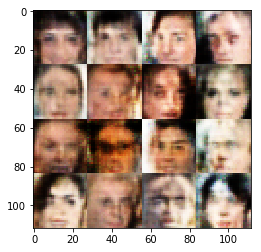

Epoch 1/1... Batch num 1425/3165... Discriminator Loss: 0.7987... Generator Loss: 0.8919
Epoch 1/1... Batch num 1450/3165... Discriminator Loss: 1.0627... Generator Loss: 0.6083
Epoch 1/1... Batch num 1475/3165... Discriminator Loss: 1.4096... Generator Loss: 0.2691
Epoch 1/1... Batch num 1500/3165... Discriminator Loss: 1.3291... Generator Loss: 0.5237


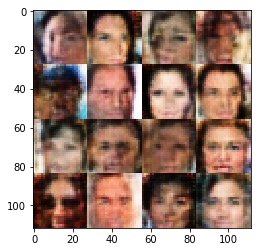

Epoch 1/1... Batch num 1525/3165... Discriminator Loss: 1.2731... Generator Loss: 0.6574
Epoch 1/1... Batch num 1550/3165... Discriminator Loss: 1.4050... Generator Loss: 0.2555
Epoch 1/1... Batch num 1575/3165... Discriminator Loss: 1.9601... Generator Loss: 0.1448
Epoch 1/1... Batch num 1600/3165... Discriminator Loss: 1.5454... Generator Loss: 0.3883


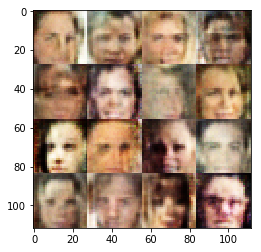

Epoch 1/1... Batch num 1625/3165... Discriminator Loss: 1.3448... Generator Loss: 0.5532
Epoch 1/1... Batch num 1650/3165... Discriminator Loss: 1.2170... Generator Loss: 0.4955
Epoch 1/1... Batch num 1675/3165... Discriminator Loss: 1.8941... Generator Loss: 1.1216
Epoch 1/1... Batch num 1700/3165... Discriminator Loss: 1.3471... Generator Loss: 0.5761


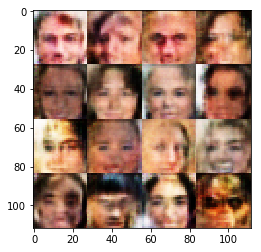

Epoch 1/1... Batch num 1725/3165... Discriminator Loss: 1.1996... Generator Loss: 0.4683
Epoch 1/1... Batch num 1750/3165... Discriminator Loss: 1.3586... Generator Loss: 0.5943
Epoch 1/1... Batch num 1775/3165... Discriminator Loss: 1.9254... Generator Loss: 1.1226
Epoch 1/1... Batch num 1800/3165... Discriminator Loss: 1.1560... Generator Loss: 0.7850


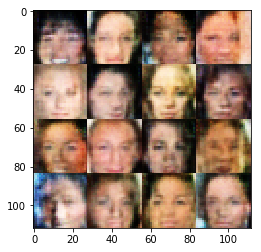

Epoch 1/1... Batch num 1825/3165... Discriminator Loss: 1.3772... Generator Loss: 0.4680
Epoch 1/1... Batch num 1850/3165... Discriminator Loss: 1.1934... Generator Loss: 0.4333
Epoch 1/1... Batch num 1875/3165... Discriminator Loss: 1.2857... Generator Loss: 0.4904
Epoch 1/1... Batch num 1900/3165... Discriminator Loss: 1.3147... Generator Loss: 0.4619


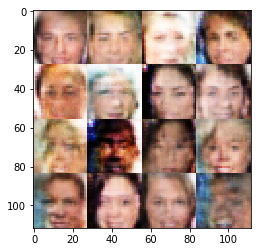

Epoch 1/1... Batch num 1925/3165... Discriminator Loss: 1.2600... Generator Loss: 0.5182
Epoch 1/1... Batch num 1950/3165... Discriminator Loss: 1.2359... Generator Loss: 0.4679
Epoch 1/1... Batch num 1975/3165... Discriminator Loss: 0.9680... Generator Loss: 0.4493
Epoch 1/1... Batch num 2000/3165... Discriminator Loss: 1.2529... Generator Loss: 0.4373


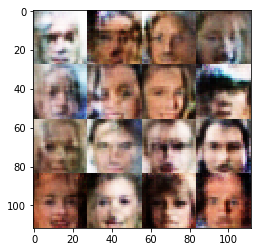

Epoch 1/1... Batch num 2025/3165... Discriminator Loss: 0.8082... Generator Loss: 0.8414
Epoch 1/1... Batch num 2050/3165... Discriminator Loss: 1.3370... Generator Loss: 0.5834
Epoch 1/1... Batch num 2075/3165... Discriminator Loss: 1.2656... Generator Loss: 0.3983
Epoch 1/1... Batch num 2100/3165... Discriminator Loss: 0.9560... Generator Loss: 0.5821


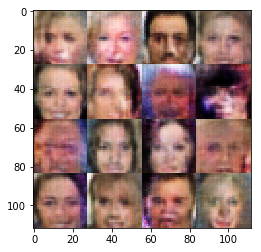

Epoch 1/1... Batch num 2125/3165... Discriminator Loss: 1.4930... Generator Loss: 0.2791
Epoch 1/1... Batch num 2150/3165... Discriminator Loss: 0.9387... Generator Loss: 0.7373
Epoch 1/1... Batch num 2175/3165... Discriminator Loss: 1.3916... Generator Loss: 0.4924
Epoch 1/1... Batch num 2200/3165... Discriminator Loss: 0.9640... Generator Loss: 0.8944


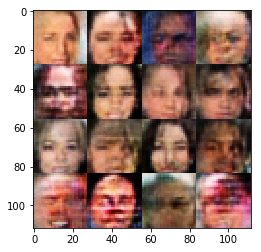

Epoch 1/1... Batch num 2225/3165... Discriminator Loss: 1.2281... Generator Loss: 0.4537
Epoch 1/1... Batch num 2250/3165... Discriminator Loss: 1.5746... Generator Loss: 1.3995
Epoch 1/1... Batch num 2275/3165... Discriminator Loss: 1.0662... Generator Loss: 0.6820
Epoch 1/1... Batch num 2300/3165... Discriminator Loss: 1.0936... Generator Loss: 0.5755


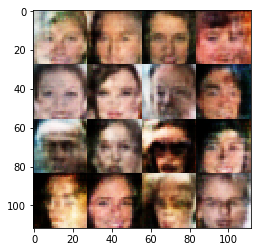

Epoch 1/1... Batch num 2325/3165... Discriminator Loss: 1.4019... Generator Loss: 0.6771
Epoch 1/1... Batch num 2350/3165... Discriminator Loss: 1.0481... Generator Loss: 0.5307
Epoch 1/1... Batch num 2375/3165... Discriminator Loss: 1.4909... Generator Loss: 0.3482
Epoch 1/1... Batch num 2400/3165... Discriminator Loss: 1.2934... Generator Loss: 0.4320


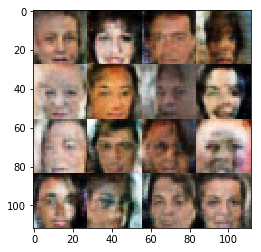

Epoch 1/1... Batch num 2425/3165... Discriminator Loss: 1.4531... Generator Loss: 0.4197
Epoch 1/1... Batch num 2450/3165... Discriminator Loss: 1.1365... Generator Loss: 0.7241
Epoch 1/1... Batch num 2475/3165... Discriminator Loss: 1.2847... Generator Loss: 0.3575
Epoch 1/1... Batch num 2500/3165... Discriminator Loss: 1.3065... Generator Loss: 0.5629


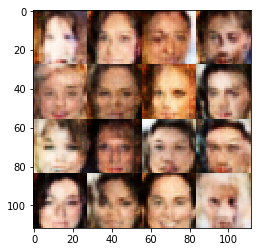

Epoch 1/1... Batch num 2525/3165... Discriminator Loss: 1.3293... Generator Loss: 0.6050
Epoch 1/1... Batch num 2550/3165... Discriminator Loss: 1.2481... Generator Loss: 0.4079
Epoch 1/1... Batch num 2575/3165... Discriminator Loss: 1.3906... Generator Loss: 0.3950
Epoch 1/1... Batch num 2600/3165... Discriminator Loss: 1.0959... Generator Loss: 0.8243


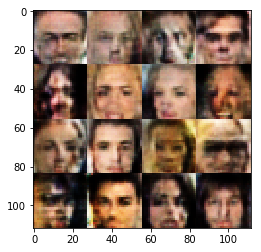

Epoch 1/1... Batch num 2625/3165... Discriminator Loss: 1.2305... Generator Loss: 0.8359
Epoch 1/1... Batch num 2650/3165... Discriminator Loss: 1.2172... Generator Loss: 0.8544
Epoch 1/1... Batch num 2675/3165... Discriminator Loss: 1.5319... Generator Loss: 0.6327
Epoch 1/1... Batch num 2700/3165... Discriminator Loss: 1.4904... Generator Loss: 0.5224


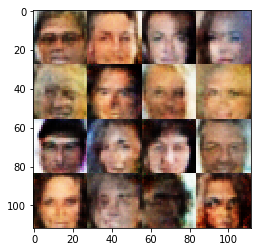

Epoch 1/1... Batch num 2725/3165... Discriminator Loss: 1.3195... Generator Loss: 0.5733
Epoch 1/1... Batch num 2750/3165... Discriminator Loss: 0.9666... Generator Loss: 0.5508
Epoch 1/1... Batch num 2775/3165... Discriminator Loss: 1.3023... Generator Loss: 0.4016
Epoch 1/1... Batch num 2800/3165... Discriminator Loss: 1.4295... Generator Loss: 0.3128


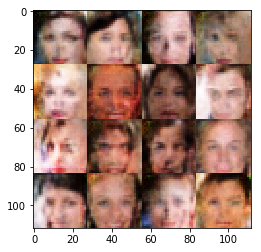

Epoch 1/1... Batch num 2825/3165... Discriminator Loss: 1.4367... Generator Loss: 0.3048
Epoch 1/1... Batch num 2850/3165... Discriminator Loss: 1.0053... Generator Loss: 0.6422
Epoch 1/1... Batch num 2875/3165... Discriminator Loss: 1.5129... Generator Loss: 0.3867
Epoch 1/1... Batch num 2900/3165... Discriminator Loss: 1.1780... Generator Loss: 0.4878


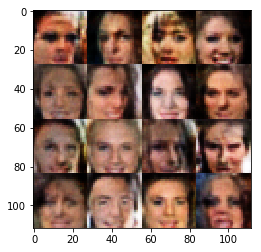

Epoch 1/1... Batch num 2925/3165... Discriminator Loss: 1.2641... Generator Loss: 0.4323
Epoch 1/1... Batch num 2950/3165... Discriminator Loss: 1.2011... Generator Loss: 0.4789
Epoch 1/1... Batch num 2975/3165... Discriminator Loss: 1.4154... Generator Loss: 0.4404
Epoch 1/1... Batch num 3000/3165... Discriminator Loss: 1.2440... Generator Loss: 0.4133


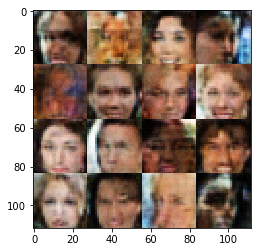

Epoch 1/1... Batch num 3025/3165... Discriminator Loss: 1.5959... Generator Loss: 0.3878
Epoch 1/1... Batch num 3050/3165... Discriminator Loss: 1.3766... Generator Loss: 0.7481
Epoch 1/1... Batch num 3075/3165... Discriminator Loss: 1.3944... Generator Loss: 0.4951
Epoch 1/1... Batch num 3100/3165... Discriminator Loss: 1.3648... Generator Loss: 0.5825


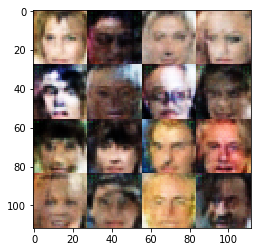

Epoch 1/1... Batch num 3125/3165... Discriminator Loss: 1.3917... Generator Loss: 0.4755
Epoch 1/1... Batch num 3150/3165... Discriminator Loss: 1.0794... Generator Loss: 0.5448


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

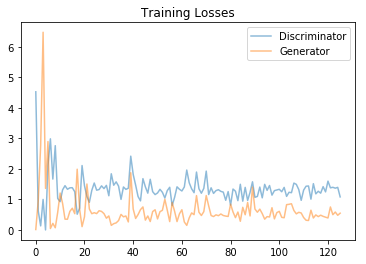

In [15]:
import matplotlib.pylab as plt

fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.